<h1>Tacotron with TensorFlow</h1>
Possible datasets (from Jira):

<a href="http://www.openslr.org/12/">open slr</a> - The data used

<a href="https://medium.com/@klintcho/creating-an-open-speech-recognition-dataset-for-almost-any-language-c532fb2bc0cf">audiobooks</a>

<a href="https://datashare.is.ed.ac.uk/handle/10283/2651">datashare</a>

<a href="https://voice.mozilla.org/en/data ">Mozilla voice</a> - just realized this is 12gb

<a href="https://ai.googleblog.com/2017/12/tacotron-2-generating-human-like-speech.html">link</a> to actual Tacotron2 thing by Google

<a href="https://github.com/r9y9/wavenet_vocoder">link</a> to wavenet vocoder

In [0]:
!apt install libsndfile1
!pip install soundfile

Run above in case the soundfile import doesn't work

In [0]:
#import statements
import tensorflow as tf
import numpy as np
import soundfile as sf
import scipy.signal as signal
import matplotlib.pyplot as plt
import os
import librosa
from sklearn.preprocessing import LabelEncoder

from google.colab import drive

I'm not sure how you want to download the data from the datasets
if you drop it into your google drive root directory, we can use code similar to the stuff below and access it. Also, do you have any prefrence on what data set to use?

In [0]:
drive.mount('/content/gdrive/')

Data preprocessing, generating spectrograms from flac files (using the libslr data, 61-70968 files uplaoded into colab).

In [0]:
def getSpec(file, dirp, save=True):
  data, samplerate = sf.read(file)
  s = melspectrogram(data,samplerate)
  if save:
    plt.pcolormesh(s)
    plt.savefig(dirp+file.split('.')[0]+'.png')
  return s
  #plt.pcolormesh(time,freq,spec) #uncomment to see the spectrogram
  #is spectrogram wavenet compatible?

In [0]:
def makeSpecs():
  #rm -r spectrograms/ #run to delete the folder
  auio_ext = "flac"
  audio_files = [s for s in os.listdir() if len(s.split('.'))>1 and s.split('.')[1] == auio_ext]
  os.makedirs('spectrograms', exist_ok=True)
  return [getSpec(file,'spectrograms/') for file in audio_files]

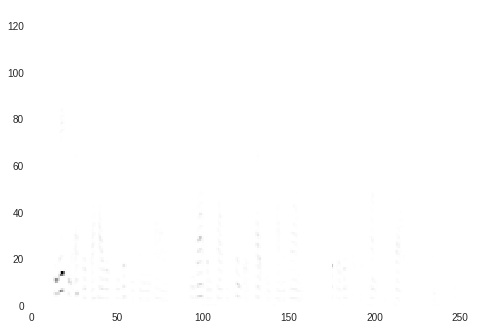

In [158]:
output_spec = makeSpecs()

In [0]:
transcript = open("61-70968.trans.txt",'r')
input_text = [s[14:] for s in transcript.read().strip().split('\n')]

Creates the text input array associated with each png, and trims the number id

array([[9.42157549e-02, 5.10279942e-02, 3.05857292e-02, ...,
        2.97752282e-02, 3.32919954e-02, 6.64239971e-02],
       [2.25256377e-01, 3.11466151e-01, 3.48730247e-01, ...,
        3.40292110e-01, 3.63837222e-01, 3.33525963e-01],
       [4.09767939e-01, 4.06295238e-01, 4.28071143e-01, ...,
        3.94537000e-01, 4.27594334e-01, 3.41218474e-01],
       ...,
       [3.35674966e-06, 5.65848098e-06, 6.06927857e-06, ...,
        5.25640117e-06, 5.57153649e-06, 3.55566657e-06],
       [3.87379064e-06, 5.93787920e-06, 4.47170654e-06, ...,
        3.32399630e-06, 4.41597586e-06, 2.84882848e-06],
       [1.82231047e-06, 2.39589387e-06, 3.19921286e-06, ...,
        5.76976906e-06, 7.30103853e-06, 5.42571646e-06]])

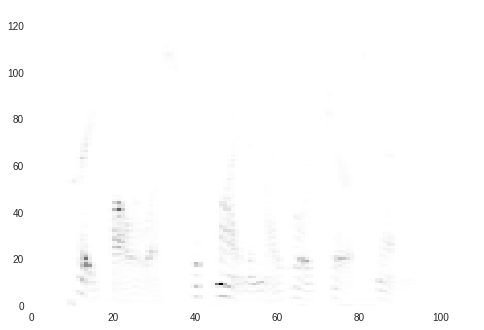

In [157]:
getSpec("61-70968-0045.flac","")

In [0]:
def melspectrogram(wav, samplerate):
	return librosa.feature.melspectrogram(wav, samplerate)

In [140]:
len(s[0])

111

In [195]:
label_encoder = LabelEncoder()
label_encoder.fit(' '.join(x for x in input_text).split(' '))#integer encode all words
input_ints = [label_encoder.transform(x) for group in input_text for x in group ]

ValueError: ignored

Stopped here because spectrograms are for sentances, and the inputs are sentances, however, if the text is broken up by word, they either loose their order (being fed in as one-hot encoded words), or as sentances in which case only inputed sentances are inputted. The actual paper uses characters as input, but i don't know how the spectrograms from sentances can be applied to that.

Below is possible code for the actual network components, though I am uncertain about their relations/usage. Taken from https://github.com/Rayhane-mamah/Tacotron-2/blob/master/tacotron/models/modules.py


In [0]:
class EncoderRNN:
	def __init__(self, is_training, size=256, zoneout=0.1, scope=None):
		"""
		Args:
			is_training: Boolean, determines if the model is training or in inference to control zoneout
			size: integer, the number of LSTM units for each direction
			zoneout: the zoneout factor
			scope: EncoderRNN scope.
		"""
		super(EncoderRNN, self).__init__()
		self.is_training = is_training

		self.size = size
		self.zoneout = zoneout
		self.scope = 'encoder_LSTM' if scope is None else scope

		#Create forward LSTM Cell
		self._fw_cell = ZoneoutLSTMCell(size, is_training,
			zoneout_factor_cell=zoneout,
			zoneout_factor_output=zoneout,
			name='encoder_fw_LSTM')

		#Create backward LSTM Cell
		self._bw_cell = ZoneoutLSTMCell(size, is_training,
			zoneout_factor_cell=zoneout,
			zoneout_factor_output=zoneout,
			name='encoder_bw_LSTM')

	def __call__(self, inputs, input_lengths):
		with tf.variable_scope(self.scope):
			outputs, (fw_state, bw_state) = tf.nn.bidirectional_dynamic_rnn(
				self._fw_cell,
				self._bw_cell,
				inputs,
				sequence_length=input_lengths,
				dtype=tf.float32,
				swap_memory=True)

			return tf.concat(outputs, axis=2) # Concat and return forward + backward outputs


In [0]:
class EncoderConvolutions:
	"""Encoder convolutional layers used to find local dependencies in inputs characters.
	"""
	def __init__(self, is_training, hparams, activation=tf.nn.relu, scope=None):
		"""
		Args:
			is_training: Boolean, determines if the model is training or in inference to control dropout
			kernel_size: tuple or integer, The size of convolution kernels
			channels: integer, number of convolutional kernels
			activation: callable, postnet activation function for each convolutional layer
			scope: Postnet scope.
		"""
		super(EncoderConvolutions, self).__init__()
		self.is_training = is_training

		self.kernel_size = hparams.enc_conv_kernel_size
		self.channels = hparams.enc_conv_channels
		self.activation = activation
		self.scope = 'enc_conv_layers' if scope is None else scope
		self.drop_rate = hparams.tacotron_dropout_rate
		self.enc_conv_num_layers = hparams.enc_conv_num_layers

	def __call__(self, inputs):
		with tf.variable_scope(self.scope):
			x = inputs
			for i in range(self.enc_conv_num_layers):
				x = conv1d(x, self.kernel_size, self.channels, self.activation,
					self.is_training, self.drop_rate, 'conv_layer_{}_'.format(i + 1)+self.scope)
		return x



TODO: a lot, still need to implement tf session 
notes from paper: input characters use 512-dimensional embedding, stack of 3 conv. layers with 512 filters and shape 5x1 (each filter spans 5 characters followed by batch normalization and ReLU activation). the output of conv. is passed to a single bi-directional LSTM with 512 units(256 in each direction) 

In [0]:
'''From the tutorial at https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/
'''
import tensorflow as tf
from keras import backend as K
from keras import regularizers, constraints, initializers, activations
from keras.layers.recurrent import Recurrent
from keras.engine import InputSpec

tfPrint = lambda d, T: tf.Print(input_=T, data=[T, tf.shape(T)], message=d)

class AttentionDecoder(Recurrent):

    def __init__(self, units, output_dim,
                 activation='tanh',
                 return_probabilities=False,
                 name='AttentionDecoder',
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        """
        Implements an AttentionDecoder that takes in a sequence encoded by an
        encoder and outputs the decoded states
        :param units: dimension of the hidden state and the attention matrices
        :param output_dim: the number of labels in the output space

        references:
            Bahdanau, Dzmitry, Kyunghyun Cho, and Yoshua Bengio.
            "Neural machine translation by jointly learning to align and translate."
            arXiv preprint arXiv:1409.0473 (2014).
        """
        self.units = units
        self.output_dim = output_dim
        self.return_probabilities = return_probabilities
        self.activation = activations.get(activation)
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        super(AttentionDecoder, self).__init__(**kwargs)
        self.name = name
        self.return_sequences = True  # must return sequences

    def build(self, input_shape):
        """
          See Appendix 2 of Bahdanau 2014, arXiv:1409.0473
          for model details that correspond to the matrices here.
        """

        self.batch_size, self.timesteps, self.input_dim = input_shape

        if self.stateful:
            super(AttentionDecoder, self).reset_states()

        self.states = [None, None]  # y, s

        """
            Matrices for creating the context vector
        """

        self.V_a = self.add_weight(shape=(self.units,),
                                   name='V_a',
                                   initializer=self.kernel_initializer,
                                   regularizer=self.kernel_regularizer,
                                   constraint=self.kernel_constraint)
        self.W_a = self.add_weight(shape=(self.units, self.units),
                                   name='W_a',
                                   initializer=self.kernel_initializer,
                                   regularizer=self.kernel_regularizer,
                                   constraint=self.kernel_constraint)
        self.U_a = self.add_weight(shape=(self.input_dim, self.units),
                                   name='U_a',
                                   initializer=self.kernel_initializer,
                                   regularizer=self.kernel_regularizer,
                                   constraint=self.kernel_constraint)
        self.b_a = self.add_weight(shape=(self.units,),
                                   name='b_a',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        """
            Matrices for the r (reset) gate
        """
        self.C_r = self.add_weight(shape=(self.input_dim, self.units),
                                   name='C_r',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_r = self.add_weight(shape=(self.units, self.units),
                                   name='U_r',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_r = self.add_weight(shape=(self.output_dim, self.units),
                                   name='W_r',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_r = self.add_weight(shape=(self.units, ),
                                   name='b_r',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)

        """
            Matrices for the z (update) gate
        """
        self.C_z = self.add_weight(shape=(self.input_dim, self.units),
                                   name='C_z',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_z = self.add_weight(shape=(self.units, self.units),
                                   name='U_z',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_z = self.add_weight(shape=(self.output_dim, self.units),
                                   name='W_z',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_z = self.add_weight(shape=(self.units, ),
                                   name='b_z',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        """
            Matrices for the proposal
        """
        self.C_p = self.add_weight(shape=(self.input_dim, self.units),
                                   name='C_p',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_p = self.add_weight(shape=(self.units, self.units),
                                   name='U_p',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_p = self.add_weight(shape=(self.output_dim, self.units),
                                   name='W_p',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_p = self.add_weight(shape=(self.units, ),
                                   name='b_p',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        """
            Matrices for making the final prediction vector
        """
        self.C_o = self.add_weight(shape=(self.input_dim, self.output_dim),
                                   name='C_o',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_o = self.add_weight(shape=(self.units, self.output_dim),
                                   name='U_o',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_o = self.add_weight(shape=(self.output_dim, self.output_dim),
                                   name='W_o',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_o = self.add_weight(shape=(self.output_dim, ),
                                   name='b_o',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)

        # For creating the initial state:
        self.W_s = self.add_weight(shape=(self.input_dim, self.units),
                                   name='W_s',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)

        self.input_spec = [
            InputSpec(shape=(self.batch_size, self.timesteps, self.input_dim))]
        self.built = True

    def call(self, x):
        # store the whole sequence so we can "attend" to it at each timestep
        self.x_seq = x

        # apply the a dense layer over the time dimension of the sequence
        # do it here because it doesn't depend on any previous steps
        # thefore we can save computation time:
        self._uxpb = _time_distributed_dense(self.x_seq, self.U_a, b=self.b_a,
                                             input_dim=self.input_dim,
                                             timesteps=self.timesteps,
                                             output_dim=self.units)

        return super(AttentionDecoder, self).call(x)

    def get_initial_state(self, inputs):
        # apply the matrix on the first time step to get the initial s0.
        s0 = activations.tanh(K.dot(inputs[:, 0], self.W_s))

        # from keras.layers.recurrent to initialize a vector of (batchsize,
        # output_dim)
        y0 = K.zeros_like(inputs)  # (samples, timesteps, input_dims)
        y0 = K.sum(y0, axis=(1, 2))  # (samples, )
        y0 = K.expand_dims(y0)  # (samples, 1)
        y0 = K.tile(y0, [1, self.output_dim])

        return [y0, s0]

    def step(self, x, states):

        ytm, stm = states

        # repeat the hidden state to the length of the sequence
        _stm = K.repeat(stm, self.timesteps)

        # now multiplty the weight matrix with the repeated hidden state
        _Wxstm = K.dot(_stm, self.W_a)

        # calculate the attention probabilities
        # this relates how much other timesteps contributed to this one.
        et = K.dot(activations.tanh(_Wxstm + self._uxpb),
                   K.expand_dims(self.V_a))
        at = K.exp(et)
        at_sum = K.sum(at, axis=1)
        at_sum_repeated = K.repeat(at_sum, self.timesteps)
        at /= at_sum_repeated  # vector of size (batchsize, timesteps, 1)

        # calculate the context vector
        context = K.squeeze(K.batch_dot(at, self.x_seq, axes=1), axis=1)
        # ~~~> calculate new hidden state
        # first calculate the "r" gate:

        rt = activations.sigmoid(
            K.dot(ytm, self.W_r)
            + K.dot(stm, self.U_r)
            + K.dot(context, self.C_r)
            + self.b_r)

        # now calculate the "z" gate
        zt = activations.sigmoid(
            K.dot(ytm, self.W_z)
            + K.dot(stm, self.U_z)
            + K.dot(context, self.C_z)
            + self.b_z)

        # calculate the proposal hidden state:
        s_tp = activations.tanh(
            K.dot(ytm, self.W_p)
            + K.dot((rt * stm), self.U_p)
            + K.dot(context, self.C_p)
            + self.b_p)

        # new hidden state:
        st = (1-zt)*stm + zt * s_tp

        yt = activations.softmax(
            K.dot(ytm, self.W_o)
            + K.dot(stm, self.U_o)
            + K.dot(context, self.C_o)
            + self.b_o)

        if self.return_probabilities:
            return at, [yt, st]
        else:
            return yt, [yt, st]

    def compute_output_shape(self, input_shape):
        """
            For Keras internal compatability checking
        """
        if self.return_probabilities:
            return (None, self.timesteps, self.timesteps)
        else:
            return (None, self.timesteps, self.output_dim)

    def get_config(self):
        """
            For rebuilding models on load time.
        """
        config = {
            'output_dim': self.output_dim,
            'units': self.units,
            'return_probabilities': self.return_probabilities
        }
        base_config = super(AttentionDecoder, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

The below is a network thing that has been removed in recent versions of keras, so I found and copied the code. The newer version doesn't translate over as cleanly, so this seemed like the easier approach. from https://github.com/datalogue/keras-attention/issues/15

In [0]:
def _time_distributed_dense(x, w, b=None, dropout=None,
                        input_dim=None, output_dim=None,
                        timesteps=None, training=None):
  """Apply `y . w + b` for every temporal slice y of x.
  # Arguments
      x: input tensor.
      w: weight matrix.
      b: optional bias vector.
      dropout: wether to apply dropout (same dropout mask
          for every temporal slice of the input).
      input_dim: integer; optional dimensionality of the input.
      output_dim: integer; optional dimensionality of the output.
      timesteps: integer; optional number of timesteps.
      training: training phase tensor or boolean.
  # Returns
      Output tensor.
  """
  if not input_dim:
      input_dim = K.shape(x)[2]
  if not timesteps:
      timesteps = K.shape(x)[1]
  if not output_dim:
      output_dim = K.shape(w)[1]

  if dropout is not None and 0. < dropout < 1.:
      # apply the same dropout pattern at every timestep
      ones = K.ones_like(K.reshape(x[:, 0, :], (-1, input_dim)))
      dropout_matrix = K.dropout(ones, dropout)
      expanded_dropout_matrix = K.repeat(dropout_matrix, timesteps)
      x = K.in_train_phase(x * expanded_dropout_matrix, x, training=training)

  # collapse time dimension and batch dimension together
  x = K.reshape(x, (-1, input_dim))
  x = K.dot(x, w)
  if b is not None:
      x = K.bias_add(x, b)
  # reshape to 3D tensor
  if K.backend() == 'tensorflow':
      x = K.reshape(x, K.stack([-1, timesteps, output_dim]))
      x.set_shape([None, None, output_dim])
  else:
      x = K.reshape(x, (-1, timesteps, output_dim))
  return x